## Train the word2vec model with the data from clean_data/

In [1]:
from gensim.models import Word2Vec
import pandas as pd

In [2]:
fake_pii = pd.read_csv("../clean_data/Cleaned_train_text_with_pii_2018_12_29_07_26_56_266227.csv")

In [3]:
fake_pii.head()

,Text,Labels,PII,Cleaned_text
0,Return never place become nearly movement. No ...,Address,"9479 Ward Creek Suite 474 Warnershire, NH 08434",return never place become nearly movement no s...
1,Quality recently seek Suite 937 goal relations...,Address,Suite 937,quality recently seek suite 937 goal relations...
2,Word expert reveal effect response forward. In...,Address,Apt. 925,word expert reveal effect response forward ind...
3,Son specific think. Conference its home expert...,Address,"15286 Ramirez Lakes Apt. 147 West Anthony, FL ...",son specific think conference its home expert ...
4,Control trouble Apt. 223 keep action rule. Sol...,Address,Apt. 223,control trouble apt 223 keep action rule soldi...


In [4]:
context_sentences = [sentence.split(" ") for sentence in fake_pii.Cleaned_text]

In [5]:
%%time 
word2vec_model = Word2Vec(context_sentences, size = 100, window=5,
                                  min_count = 1, workers = 2)

CPU times: user 2min 23s, sys: 519 ms, total: 2min 24s
Wall time: 1min 17s


In [6]:
file_name = "./word2vec/"+"word2vec_cleaned_300_"+".bin"
word2vec_model.save(file_name)

## Visualize the resulting word2vec model vectors in 2d with PCA.

In [7]:
from yellowbrick.features.pca import PCADecomposition
import matplotlib.pyplot as plt

In [8]:
from word2vec_visualizer import find_part_pii, get_pii2vec_matrix, color_dict

In [9]:
from tqdm import tqdm
pii_list = [find_part_pii(text, model = word2vec_model) for text in tqdm(fake_pii["Cleaned_text"]) ]

100%|██████████| 800000/800000 [01:19<00:00, 10052.91it/s]


In [10]:
pii_matrix = get_pii2vec_matrix(pii_list = pii_list, model = word2vec_model)

100%|██████████| 800000/800000 [00:02<00:00, 288888.04it/s]


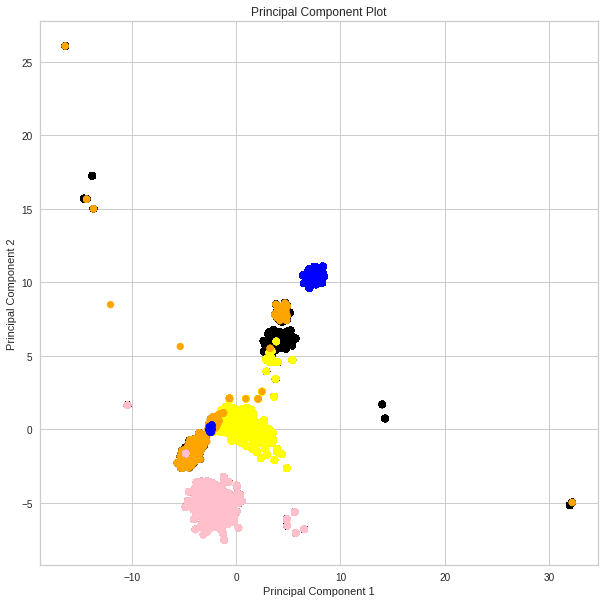

In [11]:
pii_labels = fake_pii["Labels"]
colors_map = pii_labels.map(color_dict)


plt.figure(figsize=(10,10))
PCAvisualizer = PCADecomposition(scale=True, color = colors_map, proj_dim = 2)
PCAvisualizer.fit_transform(pii_matrix, pii_labels)
PCAvisualizer.poof()

In [26]:
%%time

from sklearn.linear_model import LogisticRegression

lr_multi = LogisticRegression(random_state=0, multi_class='multinomial',solver='lbfgs',max_iter=10000)

lr_multi.fit(pii_matrix, fake_pii["Labels"])


CPU times: user 7min 31s, sys: 2min 48s, total: 10min 19s
Wall time: 4min 20s


In [ ]:
prediction = lr_multi.predict(pii_matrix)


def binary_pii(label):
    pii_label = "No"
    if label != "None":
        pii_label = "Yes"
    return pii_label 


In [ ]:
binary_true = [binary_pii(label) for label in fake_pii["Labels"]]
binary_true = pd.Series(binary_true)
binary_true.value_counts()

In [ ]:
binary_pred = [binary_pii(label) for label in prediction]
binary_pred = pd.Series(binary_pred)
binary_pred.value_counts()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(confusion_matrix(y_true = binary_true, y_pred = binary_pred), annot = True,fmt="d")
plt.xlabel("Predicted values")
plt.ylabel("True values")

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
%%time
print(classification_report(y_true = binary_true, y_pred = binary_pred))

In [ ]:
%%time
print(classification_report(y_true = fake_pii["Labels"], y_pred = prediction))

# Appendix

In [21]:
import inspect

In [22]:
color_dict

{'Phone_number': 'red',
 'SSN': 'blue',
 'Address': 'black',
 'Name': 'yellow',
 'Plates': 'orange',
 'CreditCardNumber': 'purple',
 'None': 'pink',
 'Email': 'tan'}

In [24]:
print(inspect.getsource(find_part_pii))

def find_part_pii(text, model, sep = " "):
    tokenized_text = text.split(sep)
    
    part_pii = model.wv.doesnt_match(tokenized_text)
    
    return part_pii    



In [25]:
print(inspect.getsource(get_pii2vec_matrix))

def get_pii2vec_matrix(pii_list, model):
    # set the matrix dimensions
    column_num = model.trainables.layer1_size
    row_num = len(pii_list)
    # initialized the matrix
    pii2vec_mat = np.zeros((row_num, column_num))
    # iterate through the pii_list and assign the vectors to matrix.
    for index, ith_pii in enumerate(tqdm(pii_list)):
        pii2vec_mat[index,:] = model.wv[ith_pii]
    
    return pii2vec_mat

